# Download Data Set

In [28]:
!gdown --id 1p1wjaqpTh_5RHfJu4vUh8JJCdKwYMHCp
!unzip lfwa.zip -d data
!gdown http://vis-www.cs.umass.edu/lfw/pairsDevTest.txt
!gdown http://vis-www.cs.umass.edu/lfw/pairsDevTrain.txt

Downloading...
From: https://drive.google.com/uc?id=1p1wjaqpTh_5RHfJu4vUh8JJCdKwYMHCp
To: /content/lfwa.zip
104MB [00:00, 201MB/s] 
Archive:  lfwa.zip
replace data/lfw2/lfw2/Aaron_Eckhart/Aaron_Eckhart_0001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Downloading...
From: http://vis-www.cs.umass.edu/lfw/pairsDevTest.txt
To: /content/pairsDevTest.txt
100% 26.0k/26.0k [00:00<00:00, 412kB/s]
Downloading...
From: http://vis-www.cs.umass.edu/lfw/pairsDevTrain.txt
To: /content/pairsDevTrain.txt
100% 56.6k/56.6k [00:00<00:00, 497kB/s]


# Imports


In [29]:
# imports
import cv2
import os
import re
import numpy as np
import matplotlib.pyplot as plt

# imports
import tensorflow as tf
import numpy as np

from keras.layers import Conv2D, Input, BatchNormalization
from keras.layers.core import Lambda, Flatten, Dense
from keras.models import Model, Sequential
from keras import backend as K
K.set_image_data_format('channels_last')
from keras.callbacks import EarlyStopping

# parameters imports
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.initializers import RandomNormal

import time

# **Load Data**
---









In [30]:
# paths
lfw2_folder_path = "data/lfw2/lfw2"
pairs_test_path = "pairsDevTest.txt"
pairs_train_path = "pairsDevTrain.txt"

NET_IMG_DIM = (115,115)
NET_INPUT_DIM = NET_IMG_DIM +(1,)

## load people paths index

In [31]:
def load_data_index(folder_path):
    """
    load index of people and their imgs from a given folder
    
    :param folder_path: str, path to the lfw2 folder with a folder for each person (named as his name)
    :return: people_dict, dict in the format { person_name: { img_id: img_full_path } }
    """
    # init
    people_dict = {}

    # load imgs
    for person_folder in os.listdir(folder_path):

        people_dict[person_folder] = {}
        person_folder_path = os.path.join(folder_path, person_folder)

        for person_img in os.listdir(person_folder_path):
            try:
                img_idx = int(re.findall(r'\d+', person_img)[0])
            except:
                continue

            person_img_path = os.path.join(person_folder_path, person_img)

            people_dict[person_folder][img_idx] = person_img_path

    return people_dict

## load test/train files


In [32]:
def get_image(name,idx,peoples,img_load_count):
    """
    get img from a given index, loading img to memory if needed and replacing its path with the img
    or returning the img if its allready in memory. when the img returns it returns after applying pre-processing to it

    :param name: str, person name to load its img
    :param idx: int, img index to load
    :param peoples: dict, people index generated by load_data_index
    :param img_load_count: int, optional counting var to pass
    :return: 
        img: ndarray of img data that is already pre-processed
        img_load_count: if img was loaded to memory will be (original img_load_count + 1) else stays as img_load_count
    """
    idx = int(idx)

    if name not in peoples or idx not in peoples[name]:
        return None, 0

    if isinstance(peoples[name][idx], str):
        # load img
        try:
            peoples[name][idx] = cv2.imread(peoples[name][idx])
        except:
            return None, 0
        img_load_count += 1

    return pre_process_img(peoples[name][idx]), img_load_count

def file_to_dataset(file_path,people_dict):
    """
    load test/train pairs file into a dataset that can be used with Keras model.
    
    :param file_path: str, test/train file path
    :param people_dict: dict, people index generated by load_data_index
    :return: 
        X: list of ndarrays shaped (n_samples,NET_IMG_DIM), a list with 2 values, one for each input in the model with the img data processed in it. 
        y: ndarray shaped (n_samples,) 
        img_load_count: int, counting how many img where loaded to index memory
    """
    lines = open(file_path, 'r').readlines()

    img_load_count = 0
    lines = [line for line in lines if len(line.split('\t')) == 3 or len(line.split('\t')) == 4]

    n_samples = len(lines)
    X = [np.zeros((n_samples,) + NET_IMG_DIM) for i in range(2)]
    y = np.zeros((n_samples,))

    for i in range(len(lines)):
        line = lines[i]

        tokens = [s for s in re.split(r'\s', line) if s != '']
        n_tokens = len(tokens)

        if n_tokens == 3:  # match sample
            img1, img_load_count = get_image(tokens[0],tokens[1],people_dict,img_load_count)
            img2, img_load_count = get_image(tokens[0],tokens[2],people_dict,img_load_count)
            y_label = 1
        elif n_tokens == 4:  # miss-match sample
            img1, img_load_count = get_image(tokens[0],tokens[1],people_dict,img_load_count)
            img2, img_load_count = get_image(tokens[2],tokens[3], people_dict,img_load_count)
            y_label = 0
        else:
            continue

        X[0][i] = img1
        X[1][i] = img2
        y[i] = y_label
    return X, y, img_load_count

# **Data Analysis + PreProccess** 

---



## Data Explore

In [33]:
peoples = load_data_index(lfw2_folder_path)

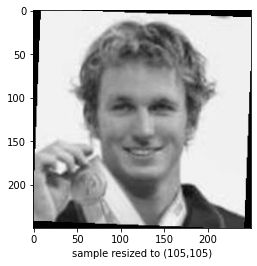

input (img) dims:  (250, 250, 3)

Total People in dataset:  5749
Max imgs for People in dataset:  530
Min imgs for People in dataset:  1
Avg imgs for People in dataset:  2.301791615933206


In [34]:
# show one img (one match and one miss match maybe)
sample_img = cv2.imread(peoples['Aaron_Peirsol'][1])
img2 = cv2.resize(sample_img,NET_IMG_DIM)
plt.imshow(sample_img)
plt.xlabel("sample resized to (105,105)")
plt.show()

# img shape
print("input (img) dims: ",sample_img.shape)

# total people in dataset
n_peoples = len(peoples)

max_imgs = 1
min_imgs = 1
avg_imgs = 0
acc_imgs = 0

for p in peoples:
  count = len(peoples[p])
  if count > max_imgs:
    max_imgs = count
  if count < min_imgs:
    min_imgs = count
  avg_imgs += count
avg_imgs /= n_peoples

print()
print("Total People in dataset: ",n_peoples)
print("Max imgs for People in dataset: ",max_imgs)
print("Min imgs for People in dataset: ",min_imgs)
print("Avg imgs for People in dataset: ",avg_imgs)

## pre proccess

In [35]:
def pre_process_img(img):
  """
    pre process img, convert it to greyscale, shrink it to NET_IMG_DIM and normalize value to range [0,1]
    
    :param img: ndarray, img to process
    :return: 
        processed: ndarray, img after pre-processing it
  """
  processed = cv2.resize(img,NET_IMG_DIM) # fit to net size (shrink)

  processed = cv2.cvtColor(processed, cv2.COLOR_BGR2GRAY) # to gray scale

  return processed / 255. # normalize values to range [0,1]

## DataSets Info

In [36]:
X_train, y_train, img_load_count = file_to_dataset(pairs_train_path, peoples)
X_test, y_test, img_load_count2 = file_to_dataset(pairs_test_path, peoples)

In [37]:
# train set
n_samples_train = len(y_train)
X_train_match = X_train[0][y_train == 1]
n_samples_train_match = len(X_train_match)

print("training set, #samples: ",n_samples_train, ", shape: ", X_train[0].shape)
print("training set, #samples with class 1 (match): ",n_samples_train_match)
print("training set, #samples with class 0 (miss-match): ",n_samples_train- n_samples_train_match)
print()
# test set
n_samples_test = len(y_test)
X_test_match = X_test[0][y_test.reshape(-1) == 1]
n_samples_test_match = len(X_test_match)

print("test set, #samples: ",n_samples_test, ", shape: ", X_test[0].shape)
print("test set, #samples with class 1 (match): ",n_samples_test_match)
print("test set, #samples with class 0 (miss-match): ",n_samples_test- n_samples_test_match)

# total dataset
print()
print("Total #samples: ",(n_samples_test+n_samples_train))
print("Total #samples with class 1 (match): ",(n_samples_test_match+n_samples_train_match))
print("Total #samples with class 0 (miss-match): ",(n_samples_test+n_samples_train) - (n_samples_test_match+n_samples_train_match))
print()
print("Total unique img in dataset: ",(img_load_count+img_load_count2))

training set, #samples:  2200 , shape:  (2200, 115, 115)
training set, #samples with class 1 (match):  1100
training set, #samples with class 0 (miss-match):  1100

test set, #samples:  1000 , shape:  (1000, 115, 115)
test set, #samples with class 1 (match):  500
test set, #samples with class 0 (miss-match):  500

Total #samples:  3200
Total #samples with class 1 (match):  1600
Total #samples with class 0 (miss-match):  1600

Total unique img in dataset:  4992


# **Set Up One-Shot model**

---


In [38]:
test_seed = 42
np.random.seed(test_seed)

In [39]:
parameters = {
    # format: tuple, (w,h,n_chanels)
    "in_shape": NET_INPUT_DIM,
    # CNN parameters Format: (list of tuples)
    # C_layers:    parameters[0:len(parameters)-1] --> (n_filters, filter_shape, activation_func, regularizer, other_extra_layers)
    # Dense_layer: parameters[len(parameters)-1] --> (n_flatten, activation_func, regularizer)
    "cnn_layers": [ (64, (10,10), 'relu', l2(2e-4), [BatchNormalization(),MaxPooling2D(2,2)]),
                    (128, (7,7), 'relu', l2(2e-4), [BatchNormalization(),MaxPooling2D(2,2)]),
                    (128, (4,4), 'relu', l2(2e-4), [BatchNormalization(),MaxPooling2D(2,2)]),
                    (256, (4,4), 'relu', l2(2e-4), [BatchNormalization(),MaxPooling2D(2,2)]),
                    (4096, 'sigmoid', l2(1e-3))],
    # Bias Init Format: tuple, (mean, std)
    "bias_init": (0.5,1e-2),
    # Weights Init Format: tuple, (mean, std)
    "weights_init": (0.0,1e-2),
    "dense_weights_init": (0.0,2e-1),

    "optimizer": Adam(lr = 0.001),
    "loss": "binary_crossentropy",
    "metrics": ['accuracy'],
    "callbacks": [EarlyStopping(monitor='val_loss',min_delta=0,patience=5,verbose=0, mode='auto',restore_best_weights=True)]
}

In [40]:
train_parameters = {
    "epochs": 2000,
    "val_split": 0.15,
    "batch_size": 128,
    "verbose": 1
}

In [41]:
class FacialRecognitionModel():
    """
    class that defines a ML model with CNN-siamese net architecture 
    """
    def __init__(self,parameters):
        """
        Constructor, construct net as parameters defined
        :param parameters: dict, formated as {name:value}
                    # in_shape: tuple, (w,h,n_chanels)
                    # cnn_layers: (list of tuples)
                        # C_layers:    parameters["cnn_layers"][0:len(parameters)-1] --> (n_filters, filter_shape, activation_func, regularizer, other_extra_layers)
                        # Dense_layer: parameters["cnn_layers"][len(parameters)-1] --> (n_flatten, activation_func, regularizer)
                    # bias_init: tuple, (mean, std)
                    # weights_init: tuple, (mean, std)
                    # dense_weights_init: tuple, (mean, std)
                    "optimizer": Keras API
                    "loss": Keras API
                    "metrics": Keras API
                    "callbacks": Keras API
        """
        self.create_model(parameters)

        #validate parameters

        self.optimizer = parameters["optimizer"]
        self.loss_func = parameters["loss"]
        self.metrics = parameters["metrics"]
        self.callbacks = parameters["callbacks"]

        self.net.compile(loss=self.loss_func,optimizer=self.optimizer,metrics=self.metrics)

    def create_model(self, parameters):
        """
        create a CNN-siamese model base on a given parameters and sets the object attributes
        :param parameters: dict, formated as {name:value}
                    # in_shape: tuple, (w,h,n_chanels)
                    # cnn_layers: (list of tuples)
                        # C_layers:    parameters["cnn_layers"][0:len(parameters)-1] --> (n_filters, filter_shape, activation_func, regularizer, other_extra_layers)
                        # Dense_layer: parameters["cnn_layers"][len(parameters)-1] --> (n_flatten, activation_func, regularizer)
                    # bias_init: tuple, (mean, std)
                    # weights_init: tuple, (mean, std)
                    # dense_weights_init: tuple, (mean, std)
        :return:
            siamese_net, keras model with the given parameters
        """
        # validate parameters

        # update attributes
        # input shape format: tuple, (w,h,n_chanels)
        self.in_shape = parameters["in_shape"]
        # CNN parameters Format: (list of tuples)
        # C_layers:    parameters[0:len(parameters)-1] --> (n_filters, filter_shape, activation_func, regularizer, pooling_layer)
        # Dense_layer: parameters[len(parameters)-1] --> (n_flatten, activation_func, regularizer)
        self.cnn_parameters = parameters["cnn_layers"]
        # Bias Random Init parameters Format: tuple, (mean, std)
        self.init_bias = parameters["bias_init"]
        # Weights Random Init parameters Format: tuple, (mean, std)
        self.init_weights = parameters["weights_init"]
        self.dense_init_weights = parameters["dense_weights_init"]
        

        # create CNN
        model = self.create_cnn(self.in_shape, self.cnn_parameters)

        # create Inputs + encode each of them with cnn model
        in1 = Input(self.in_shape)
        in2 = Input(self.in_shape)
        encoded_in1 = model(in1)
        encoded_in2 = model(in2)

        # create layer to compute the absolute difference between the encodings
        compute_abs = Lambda(lambda items: K.abs(items[0] - items[1]))
        distance_layer = compute_abs([encoded_in1, encoded_in2])

        # create out layer (sigmoid layer) as activation on distance to generate binary prediction
        out_layer = Dense(1, activation='sigmoid', bias_initializer=RandomNormal(mean=self.init_bias[0],stddev=self.init_bias[1]))(distance_layer)

        # Connect all parts of the custom model (functional model)
        siamese_net = Model(inputs=[in1, in2], outputs=out_layer)

        self.net = siamese_net

        return siamese_net

    def create_cnn(self, in_shape, parameters):
        """
        creates CNN keras model with a given parameters and the object attributes
        serves as a part of the siamese_net and used in the method create_model
        :param in_shape: tuple, model input shape
        :param parameters: (list of tuples)
                        # C_layers:    parameters[0:len(parameters)-1] --> (n_filters, filter_shape, activation_func, regularizer, other_extra_layers)
                        # Dense_layer: parameters[len(parameters)-1] --> (n_flatten, activation_func, regularizer)
        :return:
            model: CNN keras model with the given parameters
        """
        # Convolutional Neural Network
        model = Sequential()

        n_layers = len(parameters)

        for i in range(n_layers):
            if i == n_layers - 1:
                # Last Layer -> Dense
                n_flatten, activation_func, regularizer = parameters[i]

                model.add(Flatten())
                model.add(Dense(n_flatten, activation=activation_func, kernel_regularizer=regularizer,kernel_initializer=RandomNormal(mean=self.dense_init_weights[0],stddev=self.dense_init_weights[1]), bias_initializer=RandomNormal(mean=self.init_bias[0],stddev=self.init_bias[1])))
            else:
                # CNN Layer (Conv + Pooling)
                n_filters, filter_shape, activation_func, regularizer, other_extra_layers = parameters[i]

                if i == 0:
                    # Input Layer
                    model.add(Conv2D(n_filters, filter_shape, activation=activation_func, input_shape=in_shape,kernel_initializer=RandomNormal(mean=self.init_weights[0],stddev=self.init_weights[1]),kernel_regularizer=regularizer))
                else:
                    model.add(Conv2D(n_filters, filter_shape, activation=activation_func,kernel_initializer=RandomNormal(mean=self.init_weights[0],stddev=self.init_weights[1]), bias_initializer=RandomNormal(mean=self.init_bias[0],stddev=self.init_bias[1]),kernel_regularizer=regularizer))

                for extra_layer in other_extra_layers:
                    model.add(extra_layer)

        self.net_cnn = model
        return model

    def fit_model(self,X,y,epochs,batch_size=None,val_split=0.1,verbose=1):
        """
        fit the model, parameters the same as the keras API
        """
        return self.net.fit(X,y,epochs=epochs,batch_size=batch_size,validation_split=val_split,verbose=verbose,callbacks=self.callbacks)

    def eval_model(self,X,y,verbose=2):
        """
            evaluate the model, parameters the same as the keras API
        """
        return self.net.evaluate(X,  y, verbose=verbose)

    def summary(self):
        """
        prints a summary of the siamese model and the CNN model in it
        as the keras model.summary() API prints
        :return:
        """
        self.net.summary()
        self.net_cnn.summary()
            

In [42]:
model = FacialRecognitionModel(parameters)

In [43]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 115, 115, 1) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 115, 115, 1) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4096)         10638400    input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 4096)         0           sequential_1[0][0]         

# **Train**


---

In [44]:
def train_model(model,X_train,y_train,train_parameters):
    """
    apply model.fit with gpu if available, else with cpu
    :param model: FacialRecognitionModel
    :param X_train: list of ndarry, pair samples
    :param y_train: ndarry, labels of samples
    :param train_parameters: dict, formated as {name:value}
                    "epochs": Keras API
                    "val_split": Keras API
                    "batch_size": Keras API
                    "verbose": Keras API
    :return: 
        history, dict, train history
    """

    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        with tf.device('/cpu:0'):
            return model.fit_model(X_train, y_train, epochs=train_parameters["epochs"],batch_size=train_parameters["batch_size"],val_split=train_parameters["val_split"], verbose=train_parameters["verbose"])
    else:
        with tf.device('/device:GPU:0'):
            return model.fit_model(X_train, y_train, epochs=train_parameters["epochs"],batch_size=train_parameters["batch_size"],val_split=train_parameters["val_split"], verbose=train_parameters["verbose"])

In [45]:
history = train_model(model,X_train,y_train,train_parameters)

Epoch 1/2000
15/15 [==============================] - 7s 405ms/step - loss: 368.1493 - accuracy: 0.5860 - val_loss: 338.0349 - val_accuracy: 0.1091
Epoch 2/2000
15/15 [==============================] - 6s 384ms/step - loss: 328.4261 - accuracy: 0.6860 - val_loss: 301.0669 - val_accuracy: 0.3970
Epoch 3/2000
15/15 [==============================] - 6s 384ms/step - loss: 292.4539 - accuracy: 0.7686 - val_loss: 268.2069 - val_accuracy: 0.3273
Epoch 4/2000
15/15 [==============================] - 6s 384ms/step - loss: 260.2534 - accuracy: 0.8817 - val_loss: 238.8448 - val_accuracy: 0.3394
Epoch 5/2000
15/15 [==============================] - 6s 383ms/step - loss: 231.6307 - accuracy: 0.9331 - val_loss: 212.9268 - val_accuracy: 0.2273
Epoch 6/2000
15/15 [==============================] - 6s 385ms/step - loss: 206.2076 - accuracy: 0.9329 - val_loss: 189.4972 - val_accuracy: 0.3939
Epoch 7/2000
15/15 [==============================] - 6s 384ms/step - loss: 183.6196 - accuracy: 0.9764 - val_lo

# **Test**


---



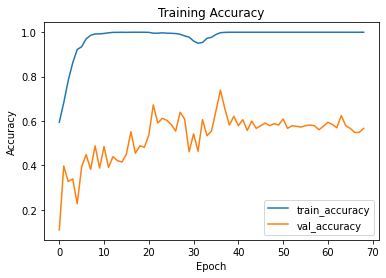

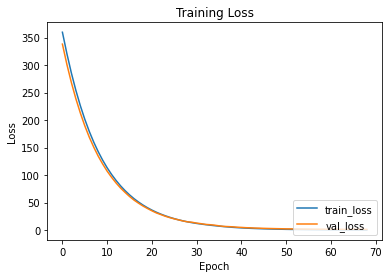

69/69 - 2s - loss: 0.4178 - accuracy: 0.9436

train acc:  0.9436363577842712
train loss:  0.41779792308807373
32/32 - 1s - loss: 0.9624 - accuracy: 0.7220

test acc:  0.722000002861023
test loss:  0.9623571038246155


In [46]:
# Evaluate the model
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.title("Training Accuracy")
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel('Epoch')
plt.title("Training Loss")
plt.ylabel('Loss')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

train_loss, train_acc = model.eval_model(X_train,  y_train , verbose=2)
print()
print("train acc: ",train_acc)
print("train loss: ",train_loss)
test_loss, test_acc = model.eval_model(X_test,  y_test , verbose=2)
print()
print("test acc: ",test_acc)
print("test loss: ",test_loss)

In [47]:
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.metrics import plot_confusion_matrix

y_pred = model.net.predict(X_test)
y_pred = np.round(y_pred)

print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))
print('Classification Report')
target_names = ['Miss-Match', 'Match']
print(classification_report(y_test, y_pred, target_names=target_names))

Confusion Matrix
[[307 193]
 [ 85 415]]
Classification Report
              precision    recall  f1-score   support

  Miss-Match       0.78      0.61      0.69       500
       Match       0.68      0.83      0.75       500

    accuracy                           0.72      1000
   macro avg       0.73      0.72      0.72      1000
weighted avg       0.73      0.72      0.72      1000



# Examples of accurate and misclassification:

In [48]:
# get test set pairs
lines = open('pairsDevTest.txt', 'r').readlines()
lines = [line for line in lines if len(line.split('\t')) == 3 or len(line.split('\t')) == 4]

In [49]:
# get correct and incorrect prediction indices
correct = []
incorrect = []
for i, x in enumerate(y_test):
  if y_test[i] == y_pred[i]:
    correct.append(i)
  else:
    incorrect.append(i)

In [50]:
first_correct_index = correct[0]
first_incorrect_index = incorrect[0]

In [51]:
# get the first correct image pair
lines[first_correct_index]

'Abdullah_Gul\t13\t14\n'

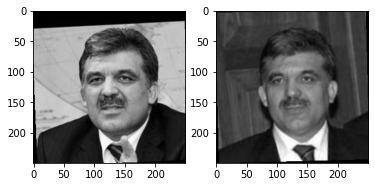

In [52]:
fig, axes = plt.subplots(1,2)
sample_img1 = cv2.imread('data/lfw2/lfw2/Abdullah_Gul/Abdullah_Gul_0013.jpg')
sample_img2 = cv2.imread('data/lfw2/lfw2/Abdullah_Gul/Abdullah_Gul_0014.jpg')
axes[0].imshow(sample_img1)
axes[1].imshow(sample_img2)
plt.show()

In [53]:
# get the first incorrect image pair
lines[first_incorrect_index]

'Amanda_Bynes\t1\t2\n'

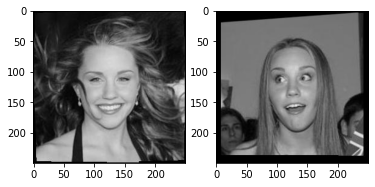

In [56]:
fig, axes = plt.subplots(1,2)
sample_img1 = cv2.imread('data/lfw2/lfw2/Amanda_Bynes/Amanda_Bynes_0001.jpg')
sample_img2 = cv2.imread('data/lfw2/lfw2/Amanda_Bynes/Amanda_Bynes_0002.jpg')
axes[0].imshow(sample_img1)
axes[1].imshow(sample_img2)
plt.show()